In [1]:
import numpy as np
import pandas as pd

keywords=pd.read_csv("database/keywords.csv").set_index('id')
#print(keywords.shape)
#display(keywords.head())

movies=pd.read_csv("database/movies_metadata.csv")#.set_index('id')
#print(movies.shape)
#display(movies.head())

/Users/katemccarthy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
#data cleaning

#poster: https://image.tmdb.org/t/p/original/[poster_path]

for index, row in movies.iterrows():
    #print(row["id"])
    #print(int(row['id']))
    if('-' not in row['id']):
        movies.iloc[index, 5] = int(row['id']) #id is a string, 
    else:
        movies.iloc[index, 5] = np.inf #Ornas!!!!

shortermovies = movies[movies['id']<26800]


In [3]:
keywords.iloc[0]['keywords']

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

In [4]:
import ast 
count = 0
def keywordextract(row):
    keys = row['keywords']
    keywords = []
    if(len(keys)>0 and ']' in keys):
        #print(keys)
        key_dict = ast.literal_eval(keys)
        for i in key_dict:
            keywords.append(i['name'])
    return keywords

df_movies = pd.DataFrame(columns = ['id', 'title', 'keywords'])
title_list = []
for index, row in shortermovies.iterrows():
    find = row['id']
    if row['adult']=='False':
        row2 = keywords.loc[find]
        keys = keywordextract(row2)
        if(len(keys)>0):
            title_list = np.append(title_list, row['title'])
            df_row = pd.DataFrame({'id':find, 'title':row['title'], 'keywords':[keys]})
            df_movies = df_movies.append(df_row)
            #print(df_row['keywords'])
        
        

In [5]:
display(df_movies.head())
print(df_movies.shape)
print(df_movies.iloc[0]['keywords'])

,id,title,keywords
0,862,Toy Story,"[jealousy, toy, boy, friendship, friends, riva..."
0,8844,Jumanji,"[board game, disappearance, based on children'..."
0,15602,Grumpier Old Men,"[fishing, best friend, duringcreditsstinger, o..."
0,11862,Father of the Bride Part II,"[baby, midlife crisis, confidence, aging, daug..."
0,949,Heat,"[robbery, detective, bank, obsession, chase, s..."


(10134, 3)
['jealousy', 'toy', 'boy', 'friendship', 'friends', 'rivalry', 'boy next door', 'new toy', 'toy comes to life']


In [6]:
#print(df_movies.iloc[0]['keywords'])

def jacc_distance(movie1, movie2):
    keys1 = movie1.keywords
    keys2 = movie2.keywords
    #print("1: ", keys1)
    #print("2: ", keys2)
    keys = keys1 + keys2
    #print(keys)
    a_and_b = []
    for key in keys:
        #print(key, type(keys1), type(keys2), type(a_and_b))
        if key in keys1 and key in keys2 and key not in a_and_b:
            a_and_b = np.append(a_and_b, key)
            #print(a_and_b)
    dist = 1-(len(a_and_b)/len(keys))
    #print("done")
    return dist
    

In [11]:
import random
class Movie:
    def __init__(self, title, keys):
        self.title = title
        self.keywords = keys
        

def kmeans(df, k=1000):
    movies = []
    for index, rows in df_movies.iterrows():
        movie = Movie(rows['title'], rows['keywords'])
        movies.append(movie)
    centroids = [[0,0,0]] * k
    clusters = [[]] * k
    
    for i in range(k):
        m = random.choice(movies)
        centroids[i] = m
        clusters[i] = [m]
    clst_num = []
    sum = 0
    for m in movies:
        if m not in centroids:
            dist = []
        #print(m.keywords)
            for j in range(len(centroids)):
                dist.append(jacc_distance(m, centroids[j])) #add two of them
            if np.sum(dist)==0:
                print("DELETED", m.title)
            else:
                index = dist.index(min(dist))
                clusters[index].append(m)
                clst_num.append(index)
            sum = sum + min(dist)
        
    meanerror = sum/len(movies)
    return centroids, clusters, meanerror, clst_num

centroids, clusters, meanerror, clst_num = kmeans(df_movies)

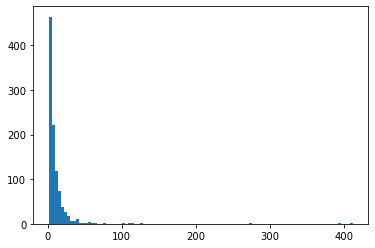

In [12]:
import matplotlib.pyplot as plt
sizes = []

for cluster in clusters:
    sizes = np.append(sizes, len(cluster))

plt.hist(sizes, bins=100)
plt.show()

In [13]:
def finder(title, clusters = clusters):
    print("Loading...")
    found = None
    given_movie = None
    for c in range(len(clusters)):
        for movie in clusters[c]:
            if title==movie.title:
                found = c
                given_movie = movie
                print("Found " + title)
                break
            if(found!=None):
                break
        if(found!=None):
            break
    movie_rec = random.choice(clusters[found])
    #print(given_movie.title)
    #for rec in clusters[c]:
    #    print(rec.title)
    print("If you liked " + title + ", we would recommend trying " + movie_rec.title)
    
    keys = given_movie.keywords + movie_rec.keywords
    #print(keys)
    the_and = []
    for k in keys:
        if k in given_movie.keywords and k in movie_rec.keywords and k not in the_and:
            the_and = np.append(the_and, k)
    strng = "They are both about "
    for a in the_and:
        strng = strng+a + " "
    print(strng)


title = input("What Movie Do You Want to Know About? ")
found = False
while not found:
    if title in title_list:
        print(title + "? Excellent Choice!")
        finder(title)
        found = True
    else:
        print(title + "? I haven't heard of that one! Can you give me another?")
        title = input("What Movie Do You Want to Know About?")


What Movie Do You Want to Know About? Toy Story
Toy Story? Excellent Choice!
Loading...
Found Toy Story
If you liked Toy Story, we would recommend trying Toy Story
They are both about jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life 


In [14]:
inp = input("Cluster:")
while inp!= "Break":
    ind = int(inp)
    for c in clusters[ind]:
        print(c.title)
    inp = input("Next: ")

Cluster:1
The Wendell Baker Story
He Got Game
Happy, Texas
People I Know
I've Loved You So Long
Gods of the Plague
The Glass Cell
Next: 4
Sukiyaki Western Django
The Bachelor
Phantom of the Opera
The Magnificent Seven
Welcome to Collinwood
House of Wax
The Eye
The Grudge
Saw
Twilight Zone: The Movie
After the Rain
Ju-on: The Grudge
Ju-on: The Grudge 2
The Amityville Horror
Dear Wendy
The Grudge 2
13 Tzameti
Hana
Sleuth
Graveyard of Honor
The Eye
The Art of Negative Thinking
Prom Night
Quarantine
Tokyo Gore Police
My Bloody Valentine
The Uninvited
Chocolate
Afro Samurai: Resurrection
The Stepfather
A Nightmare on Elm Street
12 Angry Men
The Last Airbender
Children of the Corn
Hanzo the Razor: The Snare
Hanzo the Razor: Who's Got the Gold?
The Initiation of Sarah
Red Sun
Next: Break


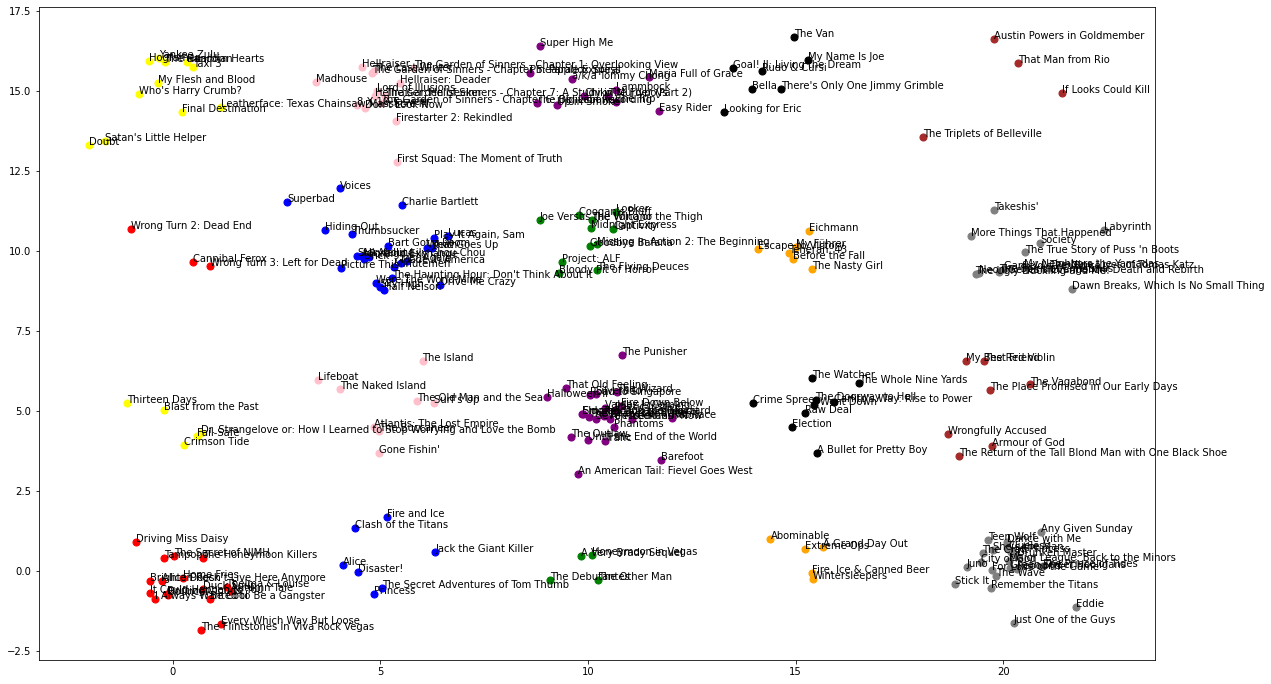

In [55]:
from sklearn.datasets import make_blobs

NUM_CLUST = 20
clust_graph = []
for i in range(NUM_CLUST):
    r = random.choice(clusters)
    while len(r)<3:
        r = random.choice(clusters)
    clust_graph.append(r)
sizes = []
for c in clust_graph:
    sizes.append(len(c))

centers = []
countx = 0
county = 0
for i in range(NUM_CLUST):
    if countx > NUM_CLUST:
        countx = 0
        county = county+5
    centers.append((countx, county))
    countx = countx+5
#centers = [(-5, -5), (5, 5)]

plt.figure(figsize=(20,12))
X, y = make_blobs(n_samples=sizes, cluster_std=0.8, centers=centers, n_features=2, random_state=1)
colors = ["red", "blue", "green", "orange","gray", "yellow","pink","purple", "black", "brown","red", "blue", "green", "orange","gray", "yellow","pink","purple", "black", "brown"]
for i in range(NUM_CLUST):
    curr_clust = clust_graph[i]
    names = []
    for movie in curr_clust:
        names.append(movie.title)
    plt.scatter(X[y==i, 0], X[y==i,1], color=colors[i], s=50)
    for j, txt in enumerate(names):
        plt.annotate(txt, (X[y==i,0][j], X[y==i,1][j]))
#plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
#plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")